## How stock_helpers.py's Functions Work

### By: Trinity Lee

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing the libraries

In [123]:
import matplotlib.pyplot as plt
import finplot as finplot
from StockPlot import StockPlot


### How the Code works
We'll be web scraping the closing prices of a stock on a given day. From here on out any time "raw stock data" is referenced, we mean the unchanged value of the closing prices of a stock, without normalization or any other additional calculations. 

The first thing we can do is set the range of dates we want to scrape

In [124]:
start_date = "2010-3-01"
end_date = "2023-2-28"

## Comparing Tesla to the Overall Market through Market Indexes
Next, for each company/index stock, we create an StockPlot object for them and put then in a list. This allows our data to be organized. The different methods associated with the each StockPlot object allows us to get different permutations of our raw stock data.  

You notice quickly that plotting the Nasdaq & the Tesla stocks on one graph lead to a useless graph because the Nasdaq index's prices are so much larger than the Tesla's stock.

To compare the behavior, we can scale the prices through normalization via the sci kit library which reduces all the values to between 0-1 while preserving the overall behavior/weight of each closing price on that given day. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


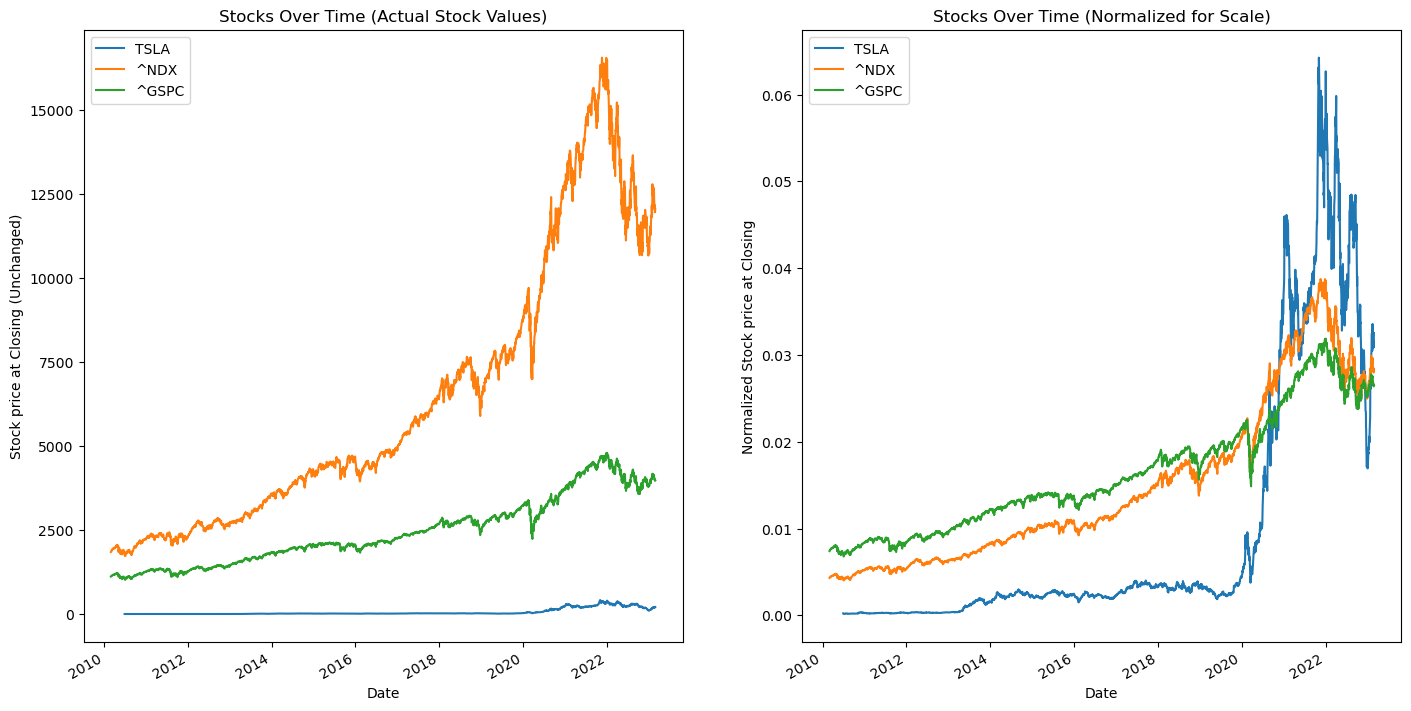

In [125]:
# Creating StockPlot Objects
tesla = StockPlot("TSLA", start_date, end_date)
nasdaq = StockPlot("^NDX", start_date, end_date)
sp500 = StockPlot("^GSPC", start_date, end_date)

#Storage for organization & easy plotting
market_list = [tesla, nasdaq,sp500]

#Settings for the graph dimensions
fig, axes = plt.subplots(2, 1, figsize=(17,9))

#SubPlot 1: Raw Closing Stock Prices
plt.subplot(1, 2, 1)
for symbol in market_list:
    symbol.get_stock_data().plot(label=symbol.get_ticker())
    
plt.ylabel("Stock price at Closing (Unchanged)")
plt.title("Stocks Over Time (Actual Stock Values)")
plt.legend()

#SubPlot 2: Normalized Closing Stock Prices
plt.subplot(1, 2, 2)
for symbol in market_list:
    symbol.get_normalized_data().plot(label=symbol.get_ticker())

plt.ylabel("Normalized Stock price at Closing")
plt.title("Stocks Over Time (Normalized for Scale)")
plt.legend()
plt.show()

### Plotting Basic Time Series

While Figure 1 illustrates that the Nasdaq stock price was larger relative to Tesla's stock closing prices, the normalized data allows draw some interesting conclusions on the overall behavior of each stock in relative to each other. We can see how the Nasdaq stock is a lot more stable overall, but that Tesla's stocks have increased dramatically in price in the recent years. 


Next, we can plot the stock percentage variance between days over this timespan. Percent variance is basically the rate of change between days in a percentage of the previous point. For example, if the stock was 100 on the first day and then 80 on the second, the percentage variance of the second day is -20% from the first day. 

Mathematically it is just (current value - previous value)/ previous value

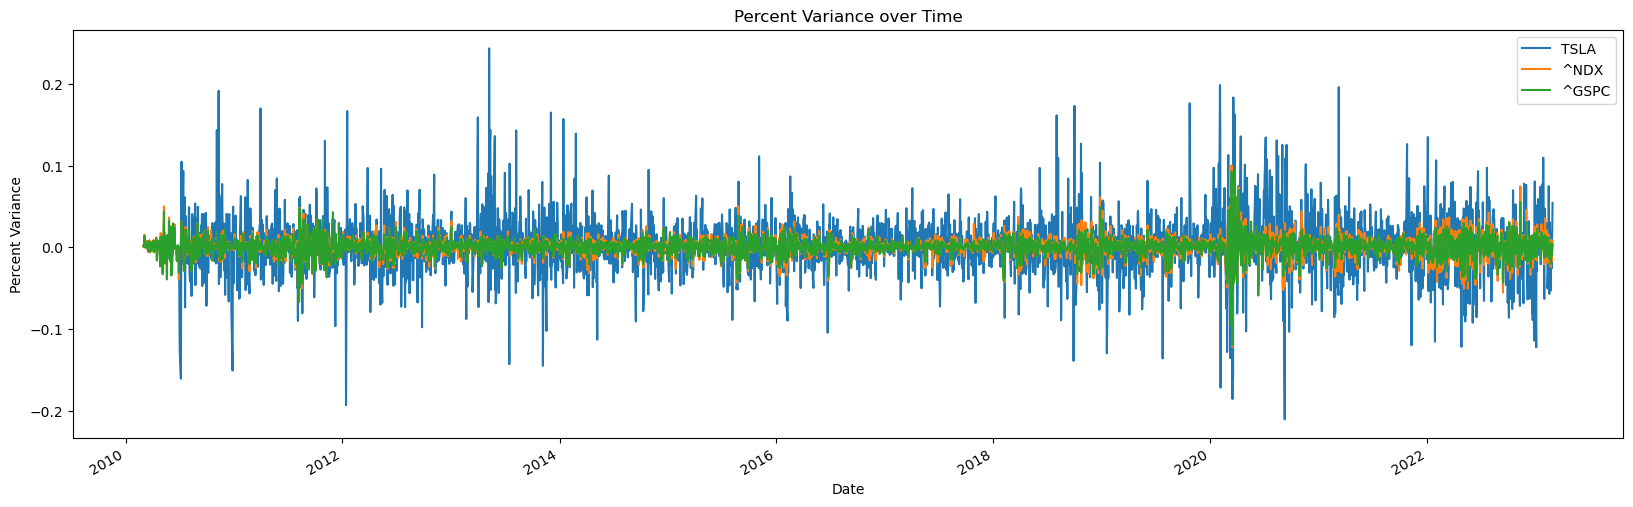

In [126]:
fig, axes = plt.subplots(1, 1, figsize=(20,6))

for symbol in market_list:
    symbol.get_variance_data().plot(label=symbol.get_ticker())

plt.legend()
plt.ylabel("Percent Variance")
plt.title("Percent Variance over Time")
plt.show()

Since we know that Tesla is a lot more volatile compared to the nasdaq, it isn't surprising that tesla has more extreme percentage variance.



### Filtering Process

All this stock analysis and plotting so far has been building up to what we want to do, which is filter out when the Tesla's stock behavior in an anomalous manner compared to the rest of the market so that we can find a list of dates that could possibly be affect by Elon Musk's tweets. The most straightforward method to filtering would be a set threshold for anomaly detection by using the percent variance of the different stocks. Whenever Tesla's percent variance for the day is decreasing (at least -2%) while the rest of the market is either stable or increasing, we want to flag and record that date as a date of interest for later event study investigation. 

In [127]:
combined_varframe = finplot.list_merger(market_list, "get_variance_data")
full_dataframe = finplot.list_merger(market_list)

filtered_dates =[]

for index, row in combined_varframe.iterrows():

    if round(row['TSLA'], 2) < -0.02 and all([round(row[str(stock.get_ticker())],2)>=0 for stock in market_list[1:]]):
        filtered_dates.append(str(index)[0:10])

#variance_dates = combined_varframe.filter(filtered_dates, axis='index')
#final_dates = full_dataframe.filter(filtered_dates, axis='index')

## Comparing with other Companies

We can do the same process as above with the stocks of companies which rival Tesla to filter our list even more.

Electric Vehicles (EV) have only become popular in the recent years. In fact, 2013 was when Tesla made its first quarterly profit, and it took until 2021 for the company to have its first profitable year. With these statistics in mind, EVs are still relatively recent, and thus not a lot of data is available on Tesla's direct competitors with the IPO dates being in only in the last several years. 

However, we can also look at non-direct EV competitors, like other automaker companies which have recently begun to go into the EV industry. A list of these companies are:

1. Rivian (Only pure EV company)
2. Toyota
3. General Motors
5. Ford

We also want to look at Tesla in the context of the Overall EV market. The Global X Autonomous & Electric Vehicles ETF (DRIV) includes companies involved in the development of autonomous vehicle software and hardware, as well as companies that produce EVs, EV components such as lithium batteries, and critical EV materials such as lithium and cobalt.




### Automaker Competitors

we use the same method as before except we don't need to plot a normalized graph as the stock prices are all of companies, not indexes. For convenience reasons, we decided to set it to the same range as when we were looking at Tesla vs the Market Indexes 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


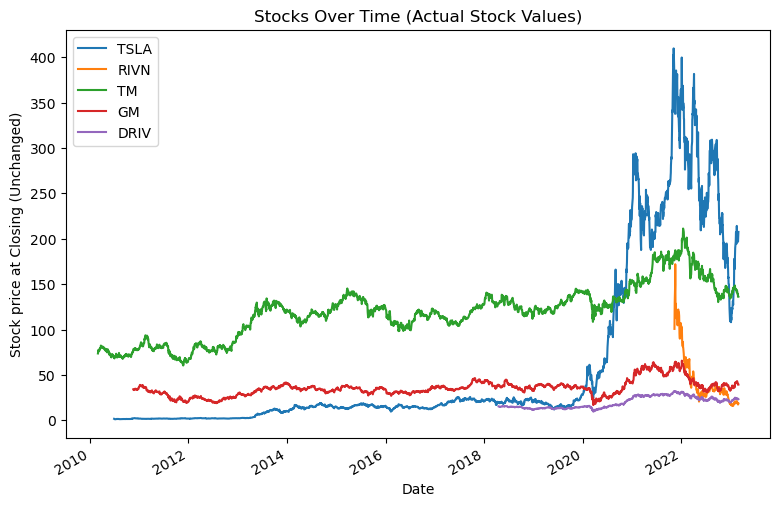

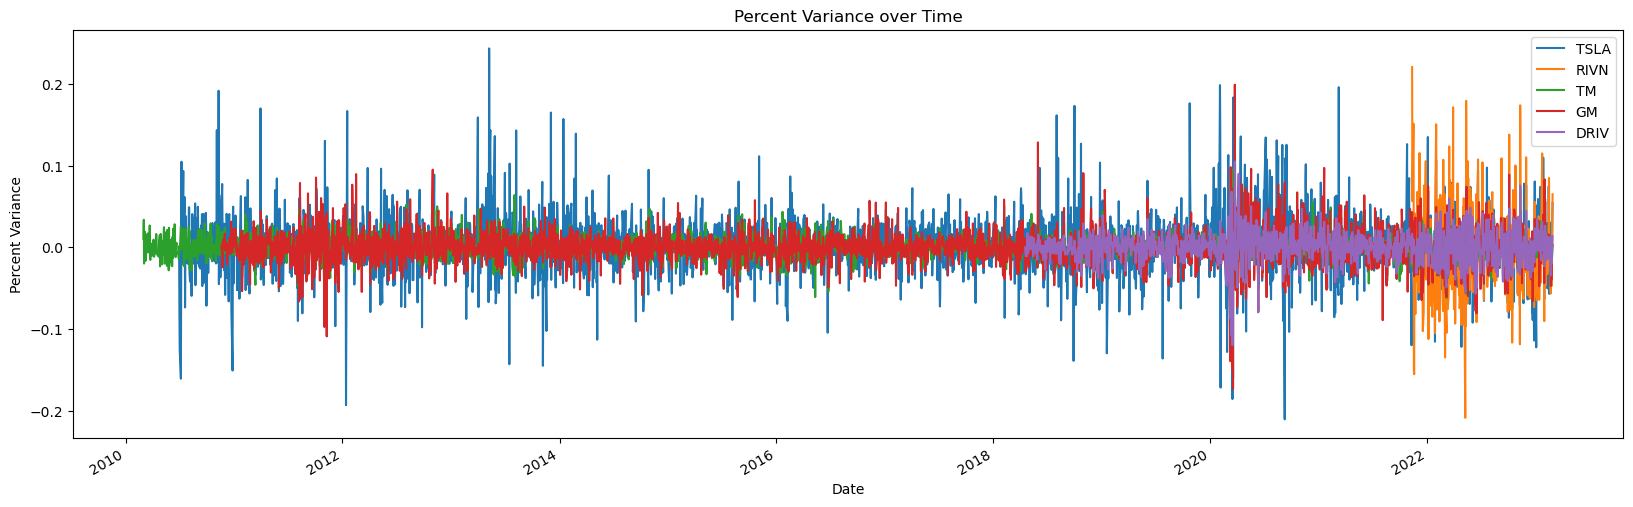

['2021-11-12', '2022-08-11', '2022-12-07']


In [133]:
rivian = StockPlot("RIVN", start_date, end_date)
toyota = StockPlot("TM", start_date, end_date)
generalmo = StockPlot("GM", start_date, end_date)

ev_etf = StockPlot("DRIV", start_date, end_date)



market_list = [tesla, rivian, toyota, generalmo]

#####################Automatically Calculates Everything#################################################################

#Settings for the graph dimensions
fig, axes = plt.subplots(1, 1, figsize=(20,6))

#SubPlot 1: Raw Closing Stock Prices
plt.subplot(1, 2, 1)
for symbol in market_list:
    symbol.get_stock_data().plot(label=symbol.get_ticker())
    
plt.ylabel("Stock price at Closing (Unchanged)")
plt.title("Stocks Over Time (Actual Stock Values)")
plt.legend()

#Percent Variance

fig, axes = plt.subplots(1, 1, figsize=(20,6))

for symbol in market_list:
    symbol.get_variance_data().plot(label=symbol.get_ticker())

plt.legend()
plt.ylabel("Percent Variance")
plt.title("Percent Variance over Time")
plt.show()

#Filtering Dates
combined_varframe = finplot.list_merger(market_list, "get_variance_data")
full_dataframe = finplot.list_merger(market_list)
filtered_dates_nondirect=[]

for index, row in combined_varframe.iterrows():

    if round(row['TSLA'], 2) < -0.02 and all([round(row[str(stock.get_ticker())],2)>=0 for stock in market_list[1:]]):
        filtered_dates_nondirect.append(str(index)[0:10])

print(filtered_dates_nondirect)


[*********************100%***********************]  1 of 1 completed


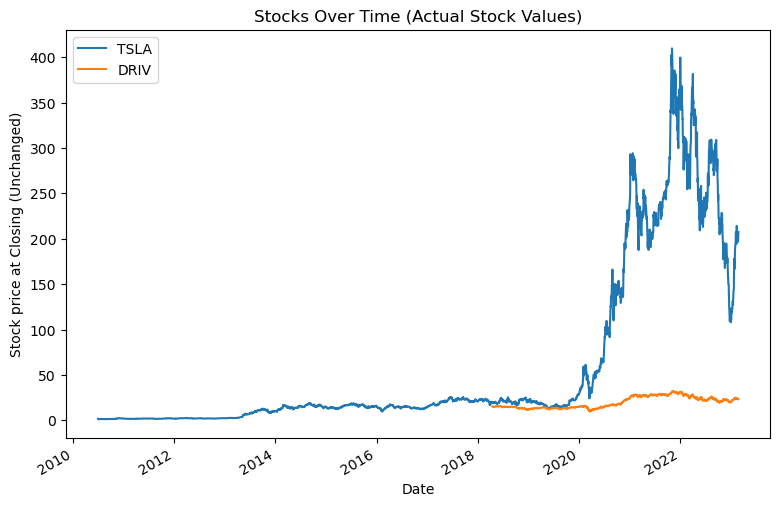

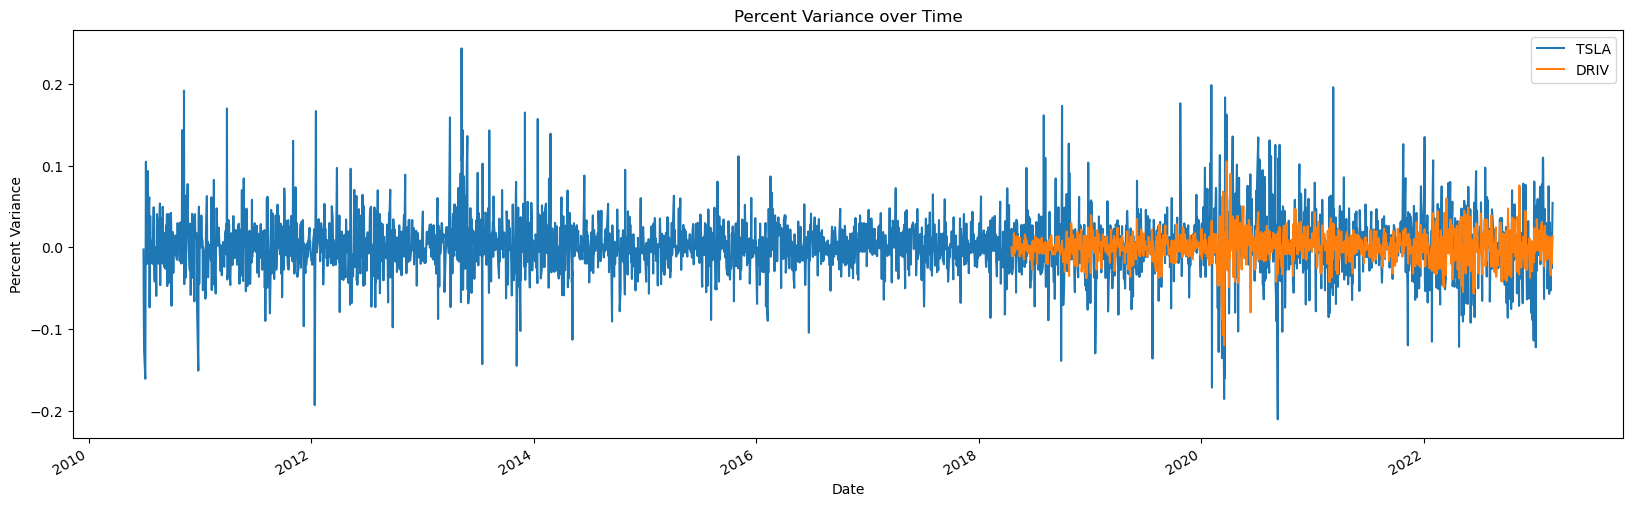

['2018-05-03', '2018-05-14', '2018-05-18', '2018-05-22', '2018-06-22', '2018-07-23', '2018-08-09', '2018-08-17', '2018-09-18', '2018-09-28', '2018-10-02', '2018-11-21', '2018-11-23', '2018-12-18', '2019-01-02', '2019-01-18', '2019-01-23', '2019-03-01', '2019-03-04', '2019-03-12', '2019-03-15', '2019-04-04', '2019-04-11', '2019-04-22', '2019-04-26', '2019-06-03', '2019-06-20', '2019-10-03', '2019-11-22', '2020-02-05', '2020-02-26', '2020-03-18', '2020-04-02', '2020-04-23', '2020-04-28', '2020-06-12', '2020-08-11', '2020-09-01', '2020-09-02', '2020-09-17', '2020-09-22', '2020-10-15', '2020-11-10', '2020-12-02', '2020-12-21', '2021-02-10', '2021-03-05', '2021-03-16', '2021-03-26', '2021-04-14', '2021-04-27', '2021-05-03', '2021-05-13', '2021-06-02', '2021-06-03', '2021-11-02', '2021-11-08', '2021-11-12', '2021-11-23', '2022-01-04', '2022-02-02', '2022-08-05', '2022-08-11', '2022-10-03', '2022-11-04', '2022-11-07', '2022-11-08', '2022-12-07', '2022-12-12', '2022-12-13', '2022-12-14', '2022

In [134]:
ev_etf = StockPlot("DRIV", start_date, end_date)

market_list = [tesla, ev_etf]

#####################Automatically Calculates Everything#################################################################

#Settings for the graph dimensions
fig, axes = plt.subplots(1, 1, figsize=(20,6))

#SubPlot 1: Raw Closing Stock Prices
plt.subplot(1, 2, 1)
for symbol in market_list:
    symbol.get_stock_data().plot(label=symbol.get_ticker())
    
plt.ylabel("Stock price at Closing (Unchanged)")
plt.title("Stocks Over Time (Actual Stock Values)")
plt.legend()

#Percent Variance

fig, axes = plt.subplots(1, 1, figsize=(20,6))

for symbol in market_list:
    symbol.get_variance_data().plot(label=symbol.get_ticker())

plt.legend()
plt.ylabel("Percent Variance")
plt.title("Percent Variance over Time")
plt.show()

#Filtering Dates
combined_varframe = finplot.list_merger(market_list, "get_variance_data")
full_dataframe = finplot.list_merger(market_list)
filtered_dates_nondirect=[]

for index, row in combined_varframe.iterrows():

    if round(row['TSLA'], 2) < -0.02 and all([round(row[str(stock.get_ticker())],2)>=0 for stock in market_list[1:]]):
        filtered_dates_nondirect.append(str(index)[0:10])

print(filtered_dates_nondirect)